<a href="https://colab.research.google.com/github/meghaduaa/OrienterNet-demo/blob/main/orienternet_drdo3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone --quiet https://github.com/facebookresearch/OrienterNet
%cd /content/OrienterNet
!python -m pip install --progress-bar off --quiet -r requirements/demo.txt
!python -m pip install --quiet -e .
!pip install --upgrade --progress-bar off --quiet plotly

/content/OrienterNet
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
pip install jupyter-server==1.16.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.1/343.1 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: jupyter-server
    Found existing installation: jupyter_server 2.17.0
    Uninstalling jupyter_server-2.17.0:
      Successfully uninstalled jupyter_server-2.17.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab 4.4.6 requires jupyter-server<3,>=2.4.0, but you have jupyter-server 1.16.0 which is incompatible.
jupyterlab-server 2.27.3 requires jupyter-server<3,>=1.21, but you have jupyter-server 1.16.0 which is incompatible.


In [ ]:
pip install --upgrade google-colab

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files
def upload_file():
  uploaded = files.upload()
  (path, bin), *_ = uploaded.items()
  with open(path, 'wb') as fid:
    fid.write(bin)
  return path


In [ ]:
from maploc.demo import Demo
from maploc.osm.viz import GeoPlotter
from maploc.osm.tiling import TileManager
from maploc.osm.viz import Colormap, plot_nodes
from maploc.utils.viz_2d import plot_images

In [ ]:
import torch
import omegaconf
import collections
import typing

with torch.serialization.safe_globals([omegaconf.dictconfig.DictConfig]):
    demo = Demo(num_rotations=128, device='cpu')


In [ ]:
#@markdown Select one of the 4 example images or "upload!" to upload your own.
image_name = 'vancouver_1' #@param ["zurich_1", "vancouver_1", "vancouver_2", "vancouver_3", "upload!"]

#@markdown OrienterNet needs a coarse location (within ~100-200 meters) to query OpenStreetMap for the right area. This can be inferred automatically from the image EXIF metadata if there is any, but otherwise you need to provide a textual address of the area - for example the name of a building or street or neighborhood.
address = "" #@param {type:"string"}

#@markdown The search radius around the location prior.
tile_size_meters = 128 #@param [64, 128, 256, 512]

if not address:
  address = None
if image_name == "upload!":
  image_path = upload_file()
else:
  image_path = f"assets/query_{image_name}.JPG"
  if image_name == "zurich_1":
    address = "ETH CAB Zurich"
  elif image_name == "vancouver_1":
    address = "Vancouver Waterfront Station"
  else:
    address = None
print(f"Using image {image_path} with location prior '{address}'")

image, camera, gravity, proj, bbox = demo.read_input_image(
    image_path,
    prior_address=address,
    tile_size_meters=tile_size_meters,
)




Using image assets/query_vancouver_1.JPG with location prior 'Vancouver Waterfront Station'


[2025-08-30 18:28:48 maploc INFO] Using (roll, pitch) (11.961334228515625, 1.2471400499343872).
[2025-08-30 18:28:48 maploc INFO] Using prior address 'Waterfront Station, West Cordova Street, Gastown, Downtown, Vancouver, Metro Vancouver Regional District, British Columbia, V6B, Canada'


In [ ]:
from maploc.osm.viz import GeoPlotter

plot = GeoPlotter(zoom=16)
plot.points(proj.latlonalt[:2], "red", name="location prior", size=10)
plot.bbox(proj.unproject(bbox), "blue", name="map tile")

plot.fig.show()


from maploc.osm.tiling import TileManager

tiler = TileManager.from_bbox(proj, bbox + 10, demo.config.data.pixel_per_meter)
canvas = tiler.query(bbox)

[2025-08-30 18:38:12 maploc INFO] Calling the OpenStreetMap API...


[2025-08-30 18:35:45 maploc INFO] Calling the OpenStreetMap API...


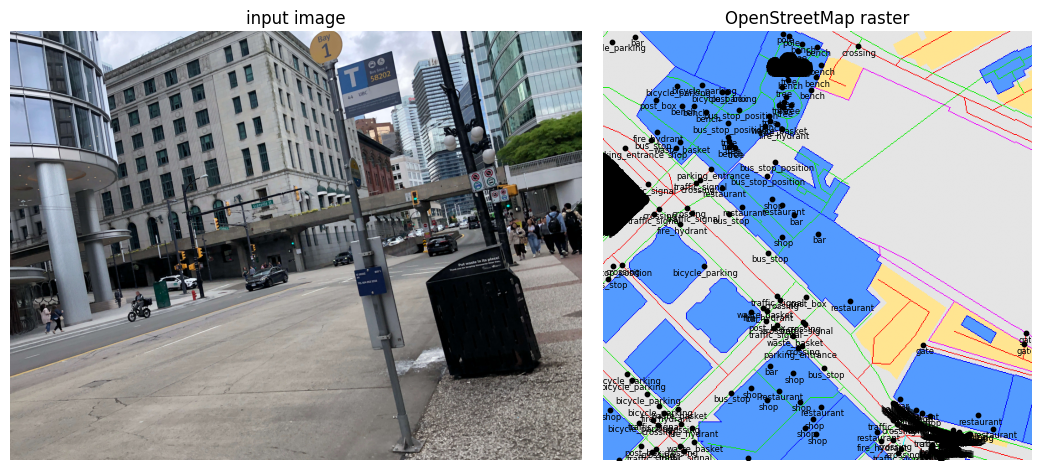

In [ ]:
# Query OpenStreetMap for this area
from maploc.osm.tiling import TileManager
tiler = TileManager.from_bbox(proj, bbox + 10, demo.config.data.pixel_per_meter)
canvas = tiler.query(bbox)

# Show the inputs to the model: image and raster map
from maploc.osm.viz import Colormap, plot_nodes
from maploc.utils.viz_2d import plot_images
map_viz = Colormap.apply(canvas.raster)
plot_images([image, map_viz], titles=["input image", "OpenStreetMap raster"])
plot_nodes(1, canvas.raster[2], fontsize=6, size=10)

In [ ]:
from maploc.utils.viz_localization import (
    likelihood_overlay,
    plot_dense_rotations,
    add_circle_inset,
)
from maploc.utils.viz_2d import features_to_RGB

uv, yaw, prob, neural_map, image_rectified = demo.localize(
    image, camera, canvas, gravity=gravity
)

/content/OrienterNet/maploc/models/voting.py:98: UserWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)



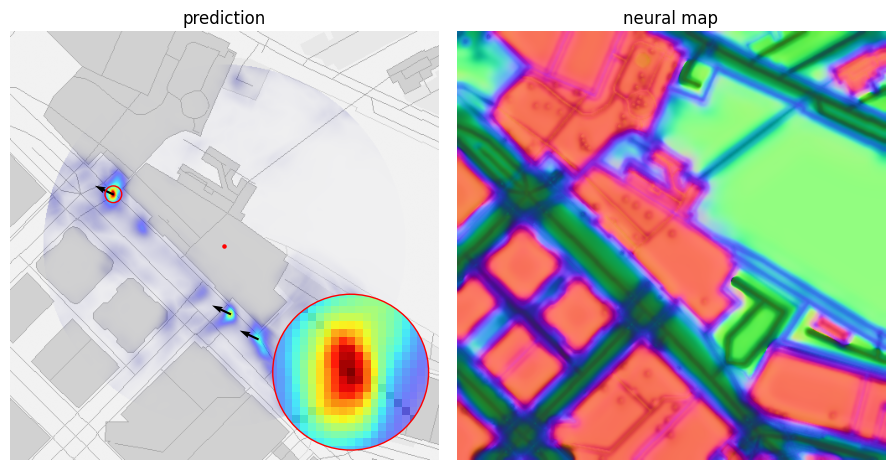

In [ ]:
# Visualize the predictions
overlay = likelihood_overlay(prob.numpy().max(-1), map_viz.mean(-1, keepdims=True))
(neural_map_rgb,) = features_to_RGB(neural_map.numpy())
plot_images([overlay, neural_map_rgb], titles=["prediction", "neural map"])
ax = plt.gcf().axes[0]
ax.scatter(*canvas.to_uv(bbox.center), s=5, c="red")
plot_dense_rotations(ax, prob, w=0.005, s=1/25)
add_circle_inset(ax, uv)
plt.show("notebook")


In [ ]:
# Plot as interactive figure
bbox_ll = proj.unproject(canvas.bbox)
plot = GeoPlotter(zoom=16.5)
plot.raster(map_viz, proj.unproject(bbox), opacity=0.5)
plot.raster(likelihood_overlay(prob.numpy().max(-1)), proj.unproject(bbox))
plot.points(proj.latlonalt[:2], "red", name="location prior", size=10)
plot.points(proj.unproject(canvas.to_xy(uv)), "black", name="argmax", size=10)
plot.bbox(proj.unproject(bbox), "blue", name="map tile")
plot.fig.show()
